In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import gzip
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.text import Tokenizer
from keras import callbacks
from nltk.corpus import stopwords

In [2]:
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield eval(l)

In [3]:
def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [4]:
df = getDF('reviews_Toys_and_Games_5.json.gz')
df = df[['reviewText', 'overall']]
df['Sentiments'] = df.overall.apply(lambda x: 0 if x in [1, 2] else 1)

In [5]:
uchar = ["*","+",",","-",".","/",":",";","<","=",">","?","@","[","\\","]","^","_","`","{","|","}","~","–","!",'"',"#","%","&","'","(",")"]
df['reviewText'] = df['reviewText'].str.lower()
for char in uchar:
 df['reviewText'] = df['reviewText'].str.replace(char, ' ',regex=True)

In [6]:
df.isna().any()

reviewText    False
overall       False
Sentiments    False
dtype: bool

In [7]:
df.head()

,reviewText,overall,Sentiments
0,i like the item pricing my granddaughter want...,5.0,1
1,love the magnet easel great for moving to d...,4.0,1
2,both sides are magnetic a real plus when you...,5.0,1
3,bought one a few years ago for my daughter and...,5.0,1
4,i have a stainless steel refrigerator therefor...,4.0,1


In [8]:
training_sentences = []
training_labels = []
testing_sentences = []
testing_labels = []

split = round(len(df)*0.8)
train_reviews = df['reviewText'][:split]
train_label = df['Sentiments'][:split]
test_reviews = df['reviewText'][split:]
test_label = df['Sentiments'][split:]

for row in train_reviews:
    training_sentences.append(str(row))
for row in train_label:
    training_labels.append(row)
for row in test_reviews:
    testing_sentences.append(str(row))
for row in test_label:
    testing_labels.append(row)

In [9]:
review_length = []
for length in training_sentences:
    review_length.append(len(length.split(' ')))
    
    #if len(length.split(' ')) < 600:
        #print(length)
        #print(len(length.split(' ')))
        #print(' ')


In [10]:
print(np.max(review_length))
print(np.percentile(review_length, 99))

6333
623.0


In [11]:
df.to_csv('cleaned_data.csv', index = False)

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['reviewText'])
print('Vocab size: ', len(tokenizer.word_index) + 1 ) 

Vocab size:  81995


In [13]:
vocab_size = 81995
embedding_dim = 17
max_length = 623
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [14]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

In [16]:
print('Final vocab count: ' + str(len(word_index)))

Final vocab count: 71438


In [17]:
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)
testing_sentences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sentences, maxlen=max_length)

In [18]:
print(training_sentences[0])

i like the item pricing  my granddaughter wanted to mark on it but i wanted it just for the letters 


In [19]:
print('Sentiments', df.Sentiments.unique())


Sentiments [1 0]


In [20]:
df.groupby('Sentiments').count()


,reviewText,overall
Sentiments,,
0,11005,11005
1,156592,156592


In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length), tf.keras.layers.GlobalAveragePooling1D(), tf.keras.layers.Dense(10, activation='relu'),  tf.keras.layers.Dense(6, activation='relu'),  tf.keras.layers.Dense(1, activation='relu')])


In [22]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 623, 17)           1393915   
                                                                 
 global_average_pooling1d (G  (None, 17)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 10)                180       
                                                                 
 dense_1 (Dense)             (None, 6)                 66        
                                                                 
 dense_2 (Dense)             (None, 1)                 7         
                                                                 
Total params: 1,394,168
Trainable params: 1,394,168
Non-trainable params: 0
______________________________________________

In [24]:
training_final = np.array(training_labels)
testing_final = np.array(testing_labels)

In [25]:
model1 = model.fit(padded, training_final, epochs=10, validation_data=(testing_padded, testing_final))

Epoch 1/10
4190/4190 [==============================] - 24s 5ms/step - loss: 0.4205 - accuracy: 0.8734 - val_loss: 0.1785 - val_accuracy: 0.9410
Epoch 2/10
4190/4190 [==============================] - 20s 5ms/step - loss: 0.1753 - accuracy: 0.9333 - val_loss: 0.1740 - val_accuracy: 0.9418
Epoch 3/10
4190/4190 [==============================] - 20s 5ms/step - loss: 0.1903 - accuracy: 0.9218 - val_loss: 0.1668 - val_accuracy: 0.9443
Epoch 4/10
4190/4190 [==============================] - 20s 5ms/step - loss: 0.1440 - accuracy: 0.9445 - val_loss: 0.1716 - val_accuracy: 0.9475
Epoch 5/10
4190/4190 [==============================] - 20s 5ms/step - loss: 0.1323 - accuracy: 0.9517 - val_loss: 0.1730 - val_accuracy: 0.9468
Epoch 6/10
4190/4190 [==============================] - 20s 5ms/step - loss: 0.1395 - accuracy: 0.9492 - val_loss: 0.1907 - val_accuracy: 0.9527
Epoch 7/10
4190/4190 [==============================] - 20s 5ms/step - loss: 0.1255 - accuracy: 0.9547 - val_loss: 0.2161 - val_ac

In [26]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", mode ="min", patience = 3, restore_best_weights = True)

model2 = model.fit(padded, training_final, epochs=15, validation_data=(testing_padded, testing_final), callbacks = [earlystopping])

Epoch 1/15
4190/4190 [==============================] - 20s 5ms/step - loss: 0.1241 - accuracy: 0.9529 - val_loss: 0.2052 - val_accuracy: 0.9531
Epoch 2/15
4190/4190 [==============================] - 20s 5ms/step - loss: 0.1326 - accuracy: 0.9519 - val_loss: 0.2355 - val_accuracy: 0.9531
Epoch 3/15
4190/4190 [==============================] - 20s 5ms/step - loss: 0.1132 - accuracy: 0.9606 - val_loss: 0.2323 - val_accuracy: 0.9522
Epoch 4/15
4190/4190 [==============================] - 21s 5ms/step - loss: 0.1128 - accuracy: 0.9607 - val_loss: 0.2402 - val_accuracy: 0.9524


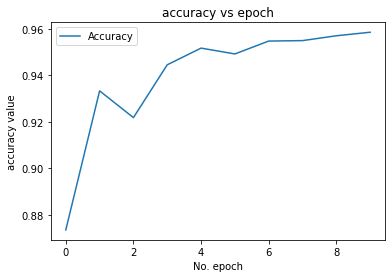

In [27]:
plt.plot(model1.history['accuracy'], label='Accuracy')
plt.title('accuracy vs epoch')
plt.ylabel('accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

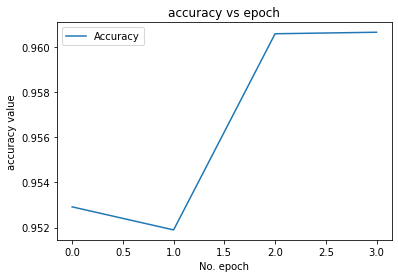

In [28]:
plt.plot(model2.history['accuracy'], label='Accuracy')
plt.title('accuracy vs epoch')
plt.ylabel('accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

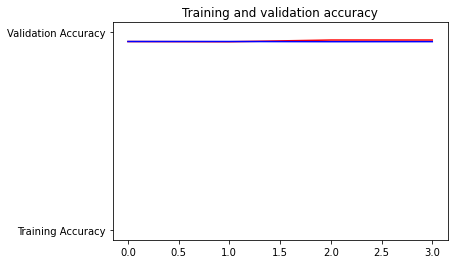

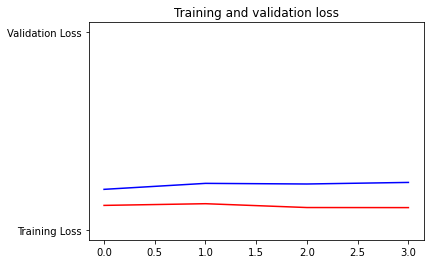

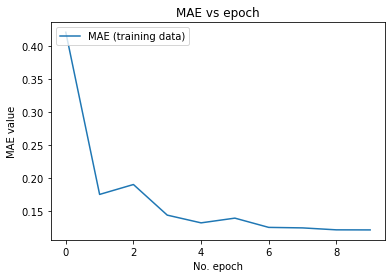

In [29]:
acc = model2.history['accuracy']
val_acc = model2.history['val_accuracy']
loss = model2.history['loss']
val_loss = model2.history['val_loss']
epochs=range(len(acc))
plt.plot(epochs, acc, 'r', 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'r', 'Training Loss')
plt.plot(epochs, val_loss, 'b', 'Validation Loss')
plt.title('Training and validation loss')
plt.figure()

plt.plot(model1.history['loss'], label='MAE (training data)')
plt.title('MAE vs epoch')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()